# Identificación de huellas de calzado a partir de imágenes con redes neuronales convolucionales 

## Autokeras

El objetivo de este apartado es entrenar la red neuronal utilizando diferentes medidas de imágenes para comprobar si el tamaño de estas afecta al resultado.

La librería autokeras se encarga de buscar la combinación de capas del modelo que puede obtener mejor resultado. A continuación, se utiliza dicha libraría para comprobar su resultado.




In [2]:

import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import skimage
import cv2 
from skimage import io


## Lectura

In [3]:
def unzipImages(folder='images'):
    with ZipFile('data/2dFootwear/Part1.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part2.zip', 'r') as zipObj:
      zipObj.extractall(folder)
    with ZipFile('data/2dFootwear/Part3.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part4.zip', 'r') as zipObj:
      zipObj.extractall(folder)

    with ZipFile('data/2dFootwear/Part5.zip', 'r') as zipObj:
      zipObj.extractall(folder)

In [4]:
if not os.path.isdir("images"):
    unzipImages()

In [5]:
df = pd.read_csv('data/2dFootwear/Data-information.csv', delimiter=';')
df['Brand'] = df['Brand'].str.strip() #eliminar espacios en blanco

X_files = df['ID'].values.tolist()
brands = df['Brand'].values.tolist()
values_brand, counts_brand = np.unique(brands, return_counts=True)
num_classes = len(values_brand) #se guarda porque será necesario para crear el modelo



In [6]:

def filterMinSamples(data, minSamples, deleteNone=True):
    if deleteNone == True:
        data=data[data['x']!="None"] #eliminar marca = "None"
    dataone=data[data['y']<minSamples] #marcas con pocas muestras
    data=data[data['y']>=minSamples] #marcas con minimo "minSamples" muestras
    num_classes=len(data)
    print('Brands with at least '+str(minSamples)+' samples: %d' %num_classes) 
    print('Brands with only 1 register: %d' %len(dataone)) 
    return data, dataone

dfbrandall = pd.DataFrame({'x':values_brand, 'y':counts_brand}) 

dfbrand, dfbrandone = filterMinSamples(dfbrandall, 5)

num_classes=len(dfbrand)
dfbrand = dfbrand.sort_values('y', ascending = False) #ordenar descendientemente




Brands with at least 5 samples: 7
Brands with only 1 register: 52


In [9]:
def crop_jpeg(crop_size, imgPath):
    dir_list = os.listdir("./"+imgPath)
    for f in dir_list:
        im = Image.open("./"+imgPath+"/"+f)
        h,w,c = im.shape
        im3 = im2.crop((crop_size,crop_size,h-(crop_size*2),w-(crop_size*2))) #Quitar marco medidor

def get_images_full_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    w, h = im.size
    im.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    img = im.crop((150,150,w-150,h-150)) #Quitar marco medidor
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result


def get_images_to_jpeg(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []

  for f in dir_list:

    im = Image.open("./"+imgPath+"/"+f)
    im2=im.resize((400,912))
    im3 = im2.crop((40,40,320,872)) #Quitar marco medidor
    im3.save("./"+imgPath+"/"+f[0:-4]+'jpeg')
    
    result.append(f[0:-4]+'jpeg')
    os.remove("./"+imgPath+"/"+f)

  print('Nº files:',len(result))
  return result

def get_images(imgPath):
  dir_list = os.listdir("./"+imgPath)
  result = []
  for f in dir_list: 
    if "jpeg" in f:
        result.append(f)


  print('Nº files:',len(result))
  return result

In [10]:
#shoeFiles = get_images_to_jpeg("images") #execute first time only
shoeFiles = get_images("images")

Nº files: 1500


### Visualización de imágenes

Se ha creado la función *plot_image* que permite la visualización de las imágenes de cualquiera de las dos bases de datos.

Parámetros:\
*imgPath*: carpeta donde estan las imágenes \
*fileNames*: array con los nombres de los ficheros a mostrar

In [11]:

import skimage
def plot_image(imgPath, fileNames):
  for i in range(len(fileNames)):
    filename = fileNames[i]
    img = skimage.io.imread(imgPath+filename)
   
    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)
  print(fileNames)
  plt.show()

def plot_image2(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img)

    plt.show()
def plot_image_grey(img):

    plt.figure()
    plt.title(str(img.shape)+" , "+str(img.dtype))
    plt.imshow(img, cmap='gray')

    plt.show()

In [12]:
def filesWithBrand(shoeFiles):
  files = []
  brands = []
  for image in shoeFiles:
    if "jpeg" in image:
        files.append(image) #filename
        person = df[df['ID'].str[:6]==image[:6]]  #persona+contador de calzado
        brands.append(person['Brand'].iloc[0])

  return pd.DataFrame({'X':files, 'y':brands}) 

def filterBrands(data, one, deleteNone=True):
    #dfbrandone creado antes con las marcas que no cumplen.
    df_shoe_brand=data[~data['y'].isin(one['x'].to_numpy())]
    
    if deleteNone == True:
        df_shoe_brand=df_shoe_brand[df_shoe_brand['y']!="None"]
    
    
    df_shoe_brand['factor_brand'] = pd.Categorical(pd.factorize(df_shoe_brand['y'])[0].astype(np.float32))
    
    return df_shoe_brand

df_shoe_brand_all = filesWithBrand(shoeFiles) #contiene todas las muestras

#eliminar aquellas marcas que no aparecen mínimo en "minSample" muestras 
df_shoe_brand = filterBrands(df_shoe_brand_all,dfbrandone)
#número de marcas con 5 o más muestras:
print('Nº of brands: %d' %num_classes)
show_brands = df_shoe_brand.drop_duplicates(subset = "y")
show_brands = show_brands[['y','factor_brand']]
#show_brands

Nº of brands: 7


In [13]:
def checkBalancedSample(train, test, val):
    checkTest = False
    checkVal = False
    
    #Comprobar si existen en train
    test_in = test.y.isin(train.y).astype(int)
    val_in=val.y.isin(train.y).astype(int)

    #Comprobar que existen todos (todo 1)  
    if all(x==1 for x in test_in):
        checkTest = True
    if all(x==1 for x in val_in):
        checkVal = True
    #Devuelve True si en test y val aparecen marcas que existen en train:
    if checkTest and checkVal:
        return True
    return False

In [14]:
from sklearn.model_selection import train_test_split
def  split_datafiles(df):
  X_train, X_test = train_test_split(df, test_size=0.2 , random_state=random.randint(0,32),shuffle=True)

  X_train, X_val = train_test_split(X_train, test_size=0.14, random_state=random.randint(0,32),shuffle=True) # 0.14 x 0.7 = 0.1
  return X_train,  X_test ,X_val

#Dividir conjunto de datos:
#shoes_train, shoes_test, shoes_val = split_datafiles(df)
shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)

while checkBalancedSample(shoes_train, shoes_test, shoes_val) == False:
    shoes_train, shoes_test, shoes_val = split_datafiles(df_shoe_brand)

In [15]:

def plot_history(history):
# summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_history_2(history):
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [16]:
def showResult(predicted, test, array):
    filename = test['X']
    img = skimage.io.imread("images/"+filename)
   
    plt.figure()
    plt.title(test['y']+" "+str(test['factor_brand']))
    plt.imshow(img)
    if array == True:
        print(predicted)
        sort_index = np.argsort(-predicted)
        print(sort_index)
    else:
        print(predicted)

In [17]:

def checkAccuracyFirstPositions(predicted_y, shoes_test, x):
    total = len(predicted_y)
    ok = 0
    for i in range(total):
        if getXfirstOk(predicted_y[i],shoes_test.iloc[i],x):
            ok = ok+1

    print(ok)
    print(ok/total)


In [18]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,ConfusionMatrixDisplay
def printConfMatrix(predicted, test,n):
    #sort_index = np.argsort(-predicted)
    cm = confusion_matrix(test['y'],predicted)

    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = range(n))

    cm_display.plot()
    plt.show() 

In [19]:
#Devuelve el % de veces que la marca se predijo con un porcentage >= minPercent
#Porcentaje de aceptación.
def checkBrandPercent(predicted_y, shoes_test, minPercent):
    total = len(predicted_y)
    ok = 0
    for i in range(total):
        #print(shoes_test['factor_brand'].iloc[i])
        #print(predicted_y[int(shoes_test['factor_brand'].iloc[i])])
        if predicted_y[int(shoes_test['factor_brand'].iloc[i])] >= minPercent: 
            ok = ok+1

    print(ok/total)


### Instalación y ejecución de AutoKeras

In [36]:
!pip install autokeras


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [37]:
import autokeras as ak

In [38]:
#https://autokeras.com/image_classifier/
#https://medium.com/analytics-vidhya/how-to-use-autokeras-to-build-image-classification-models-using-one-line-of-code-c35b0c36e66e

X = np.empty([280,832], dtype=int)

X = np.array([io.imread("images/"+p) for p in shoes_train.X.values])

print(X.shape)


(529, 832, 280, 3)


In [39]:
def executeModelAutoKeras(epoch, train, test2, val, df, n):
    X = np.empty([280,832], dtype=int)
    X = np.array([io.imread("images/"+p) for p in train.X.values])
    print(X.shape)
    
    clf = ak.ImageClassifier( num_classes=n, max_trials=1,loss = 'binary_crossentropy',
     objective='val_accuracy')
    autohistory = clf.fit(X, train['y'],epochs=epoch, validation_split = 0.2)
    
    model = clf.export_model()
    # Capas que ha creado como mejor modelo:
    model.summary()
    plot_history_2(autohistory)
    
    
    
    return clf

In [50]:
def evaluateAutoModel(model, test2,df, n):
    # Predicción con el modelo escogido por autokeras.
    t = np.empty([280,832], dtype=int)
    t = np.array([io.imread("images/"+p) for p in test2.X.values])
    predicted_auto_y = model.predict(t)
    
    print("Test evaluation:")
    print(model.evaluate(t, test2['y']))
    #print(model.evaluate(test2)) #first position
    #print("% of correct brand in the first 3 positions:")
    #checkAccuracyFirstPositions(predicted_auto_y, test2,3)
    
    if n<=20:
        print("Matriz de confusión:") 
        printConfMatrix(predicted_auto_y,test2,n)

In [41]:
def returnDataByMinSample ( minSample, deleteNone=True):
    dfbrandMin, dfbrandoneMin = filterMinSamples(dfbrandall, minSample, deleteNone)
    num_classesMin=len(dfbrandMin)
    df_shoe_brandMin = filterBrands(df_shoe_brand_all,dfbrandoneMin, deleteNone)
    print(df_shoe_brandMin)

    shoes_trainMin, shoes_testMin, shoes_valMin = split_datafiles(df_shoe_brandMin)

    while checkBalancedSample(shoes_trainMin, shoes_testMin, shoes_valMin) == False:
        shoes_trainMin, shoes_testMin, shoes_valMin = split_datafiles(df_shoe_brandMin)
    
    return num_classesMin, df_shoe_brandMin, shoes_trainMin, shoes_testMin, shoes_valMin

In [42]:
num_classes5, df_shoe_brand5,shoes_train5, shoes_test5, shoes_val5 = returnDataByMinSample(5)

Brands with at least 5 samples: 7
Brands with only 1 register: 52
                     X         y factor_brand
3     009_08_R_05.jpeg     Asics          0.0
8     010_01_L_01.jpeg  Skechers          1.0
13    025_05_R_01.jpeg     Asics          0.0
15    020_03_R_03.jpeg    Sperry          2.0
17    011_03_L_04.jpeg    Adidas          3.0
...                ...       ...          ...
1490  020_02_L_01.jpeg  Skechers          1.0
1493  011_01_R_04.jpeg    Adidas          3.0
1494  026_07_L_03.jpeg   Saucony          6.0
1496  018_04_R_02.jpeg    Sperry          2.0
1499  025_03_L_04.jpeg      Nike          4.0

[770 rows x 3 columns]


Brands with at least 5 samples: 7
Brands with only 1 register: 52
                     X         y factor_brand
3     009_08_R_05.jpeg     Asics          0.0
8     010_01_L_01.jpeg  Skechers          1.0
13    025_05_R_01.jpeg     Asics          0.0
15    020_03_R_03.jpeg    Sperry          2.0
17    011_03_L_04.jpeg    Adidas          3.0
...                ...       ...          ...
1490  020_02_L_01.jpeg  Skechers          1.0
1493  011_01_R_04.jpeg    Adidas          3.0
1494  026_07_L_03.jpeg   Saucony          6.0
1496  018_04_R_02.jpeg    Sperry          2.0
1499  025_03_L_04.jpeg      Nike          4.0

[770 rows x 3 columns]
(529, 832, 280, 3)
INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json


INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
17/17 [==============================] - 193s 11s/step - loss: 69.7915 - accuracy: 0.1531
Epoch 2/10
17/17 [==============================] - 234s 14s/step - loss: 1.9212 - accuracy: 0.3157
Epoch 3/10
17/17 [==============================] - 223s 13s/step - loss: 1.8689 - accuracy: 0.3611
Epoch 4/10
17/17 [==============================] - 217s 13s/step - loss: 1.6407 - accuracy: 0.3403
Epoch 5/10
17/17 [==============================] - 222s 13s/step - loss: 0.9814 - accuracy: 0.8336
Epoch 6/10
17/17 [==============================] - 222s 13s/step - loss: 0.2169 - accuracy: 0.9698
Epoch 7/10
17/17 [==============================] - 234s 14s/step - loss: 0.0434 - accuracy: 0.9943
Epoch 8/10
17/17 [==============================] - 209s 12s/step - loss: 0.0092 - accuracy: 1.0000
Epoch 9/10
17/17 [==============================] - 213s 13s/step - loss: 0.0048 - accuracy: 1.0000
Epoch 10/10
17/17 [==============================] - 212s 12s/step - loss: 0.0027 - accuracy: 1.000

INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 832, 280, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 832, 280, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 832, 280, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 830, 278, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 828, 276, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 414, 138, 64)     0     

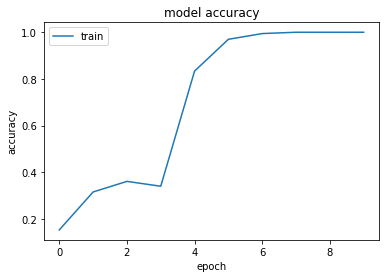

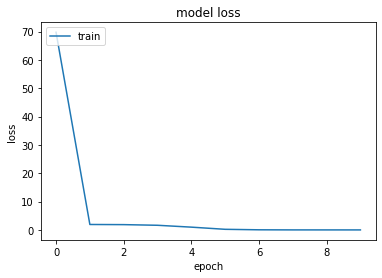

In [137]:
model_10_5 = executeModelAutoKeras(10,shoes_train5, shoes_test5, shoes_val5, df_shoe_brand5,num_classes5 )

5/5 [==============================] - 12s 2s/step
Test evaluation:
5/5 [==============================] - 15s 3s/step - loss: 1.8039 - accuracy: 0.4545
[1.8038644790649414, 0.4545454680919647]
Matriz de confusión:


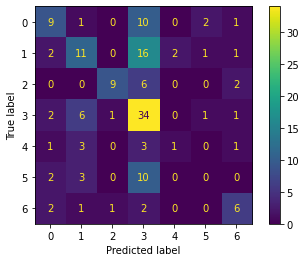

In [160]:
evaluateAutoModel(model_10_5,shoes_test5,df_shoe_brand5,num_classes5 )

(529, 832, 280, 3)
INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
INFO:tensorflow:Oracle triggered exit
Epoch 1/25
17/17 [==============================] - 193s 11s/step - loss: 77.5774 - accuracy: 0.1361
Epoch 2/25
17/17 [==============================] - 243s 14s/step - loss: 1.9155 - accuracy: 0.3384
Epoch 3/25
17/17 [==============================] - 238s 14s/step - loss: 1.9270 - accuracy: 0.5425
Epoch 4/25
17/17 [==============================] - 204s 12s/step - loss: 1.7413 - accuracy: 0.4650
Epoch 5/25
17/17 [==============================] - 195s 11s/step - loss: 0.7695 - accuracy: 0.8091
Epoch 6/25
17/17 [==============================] - 157s 9s/step - loss: 0.0657 - accuracy: 0.9962
Epoch 7/25
17/17 [==============================] - 156s 9s/step - loss: 0

INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 832, 280, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 832, 280, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 832, 280, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 830, 278, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 828, 276, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 414, 138, 64)     0     

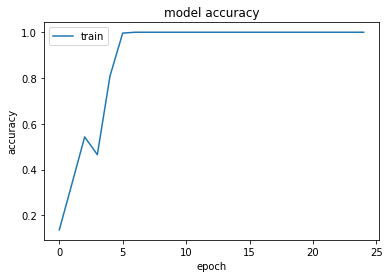

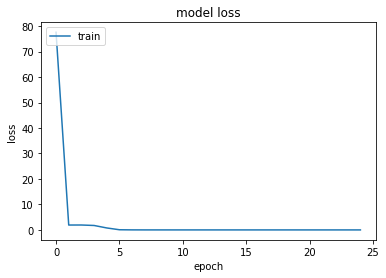

In [43]:
model_25_5 = executeModelAutoKeras(25,shoes_train5, shoes_test5, shoes_val5, df_shoe_brand5,num_classes5 )

5/5 [==============================] - 9s 2s/step
Test evaluation:
5/5 [==============================] - 10s 2s/step - loss: 1.5070 - accuracy: 0.5779
[1.5070083141326904, 0.5779221057891846]
Matriz de confusión:


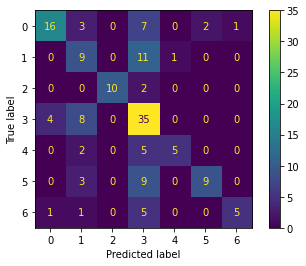

In [46]:
evaluateAutoModel(model_25_5,shoes_test5,df_shoe_brand5,num_classes5 )

In [47]:
num_classes1, df_shoe_brand1,shoes_train1, shoes_test1, shoes_val1 = returnDataByMinSample(1)


Brands with at least 1 samples: 59
Brands with only 1 register: 0
                     X         y factor_brand
0     021_05_R_03.jpeg  Champion          0.0
1     005_10_R_05.jpeg    Cooeli          1.0
2     026_06_R_01.jpeg      Keen          2.0
3     009_08_R_05.jpeg     Asics          3.0
4     020_04_R_04.jpeg      Soma          4.0
...                ...       ...          ...
1495  017_03_R_01.jpeg      Ofem         45.0
1496  018_04_R_02.jpeg    Sperry         12.0
1497  012_05_R_03.jpeg  Namuhana         42.0
1498  009_12_L_03.jpeg     Sugar         56.0
1499  025_03_L_04.jpeg      Nike         15.0

[1470 rows x 3 columns]


(1011, 832, 280, 3)
INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json


INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/10
32/32 [==============================] - 437s 13s/step - loss: 62.0615 - accuracy: 0.0959
Epoch 2/10
32/32 [==============================] - 455s 14s/step - loss: 3.5376 - accuracy: 0.2028
Epoch 3/10
32/32 [==============================] - 498s 16s/step - loss: 1.9029 - accuracy: 0.5005
Epoch 4/10
32/32 [==============================] - 492s 15s/step - loss: 0.3256 - accuracy: 0.9614
Epoch 5/10
32/32 [==============================] - 482s 15s/step - loss: 0.0266 - accuracy: 1.0000
Epoch 6/10
32/32 [==============================] - 688s 22s/step - loss: 0.0062 - accuracy: 1.0000
Epoch 7/10
32/32 [==============================] - 485s 15s/step - loss: 0.0031 - accuracy: 1.0000
Epoch 8/10
32/32 [==============================] - 547s 17s/step - loss: 0.0021 - accuracy: 1.0000
Epoch 9/10
32/32 [==============================] - 3769s 121s/step - loss: 0.0014 - accuracy: 1.0000
Epoch 10/10
32/32 [==============================] - 522s 16s/step - loss: 0.0011 - accuracy: 1.0

INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 832, 280, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 832, 280, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 832, 280, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 830, 278, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 828, 276, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 414, 138, 64)     0     

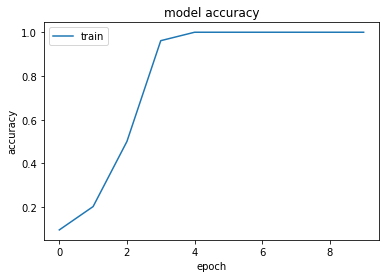

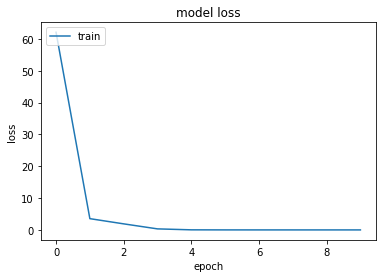

In [48]:
model_10_1 = executeModelAutoKeras(10,shoes_train1, shoes_test1, shoes_val1, df_shoe_brand1,num_classes1 )

In [51]:
evaluateAutoModel(model_10_1,shoes_test1,df_shoe_brand1,num_classes1 )

10/10 [==============================] - 18s 2s/step
Test evaluation:
10/10 [==============================] - 19s 2s/step - loss: 4.8662 - accuracy: 0.2415
[4.866211891174316, 0.24149659276008606]


(1011, 832, 280, 3)
INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json


INFO:tensorflow:Reloading Tuner from ./image_classifier/tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/25
32/32 [==============================] - 392s 12s/step - loss: 55.0381 - accuracy: 0.0613
Epoch 2/25
32/32 [==============================] - 404s 12s/step - loss: 3.8807 - accuracy: 0.1998
Epoch 3/25
32/32 [==============================] - 417s 13s/step - loss: 2.9283 - accuracy: 0.2542
Epoch 4/25
32/32 [==============================] - 469s 15s/step - loss: 1.4167 - accuracy: 0.6677
Epoch 5/25
32/32 [==============================] - 472s 15s/step - loss: 0.1990 - accuracy: 0.9832
Epoch 6/25
32/32 [==============================] - 450s 14s/step - loss: 0.0302 - accuracy: 0.9990
Epoch 7/25
32/32 [==============================] - 461s 14s/step - loss: 0.0092 - accuracy: 1.0000
Epoch 8/25
32/32 [==============================] - 454s 14s/step - loss: 0.0048 - accuracy: 1.0000
Epoch 9/25
32/32 [==============================] - 400s 12s/step - loss: 0.0030 - accuracy: 1.0000
Epoch 10/25
32/32 [==============================] - 476s 15s/step - loss: 0.0019 - accuracy: 1.000

INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 832, 280, 3)]     0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 832, 280, 3)      0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 832, 280, 3)      7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 830, 278, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 828, 276, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 414, 138, 64)     0     

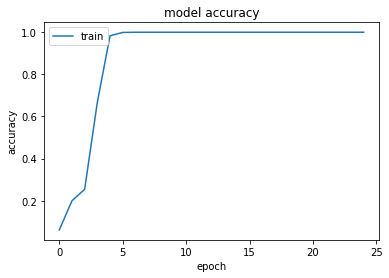

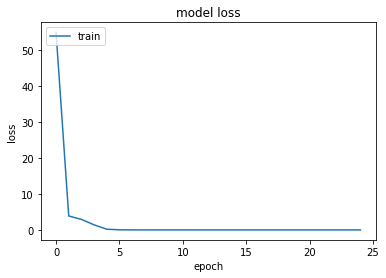

In [52]:
model_25_1 = executeModelAutoKeras(25,shoes_train1, shoes_test1, shoes_val1, df_shoe_brand1,num_classes1 )

In [53]:
evaluateAutoModel(model_25_1,shoes_test1,df_shoe_brand1,num_classes1 )

10/10 [==============================] - 34s 3s/step
Test evaluation:
10/10 [==============================] - 58s 5s/step - loss: 5.5439 - accuracy: 0.2347
[5.543888092041016, 0.23469388484954834]


## Uso de modelo pre-entrenado ImageNet

In [20]:
#Se ha creado un generador para añadir la aumentación de las imágenes
import torchvision.io
import torch
from tensorflow.keras.utils import Sequence
import torchvision.transforms as T
from torchvision.transforms import Resize
from skimage.io import imread
from skimage.util import img_as_float,random_noise
from skimage.transform import rotate
from skimage.color import rgb2gray
import numpy as np
import random
import os
from skimage import io
from skimage import transform, util



#función que elimina las filas y columnas en blanco:
def crop_image(gray, pixel_value=220):
    #gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    
    crop_rows = gray[~np.all(gray > pixel_value, axis=1), :]
    cropped_image = crop_rows[:, ~np.all(crop_rows > pixel_value, axis=0)]
    return cropped_image

def create_variation(theImage,doFlip,doNoise,doRotate):
  image = img_as_float(theImage)
  if doFlip==True:
    image = np.fliplr(image)
  if doNoise==True:
    image = util.random_noise(image)
  if doRotate==True:
    image = transform.rotate(image, random.randint(-45, 45),mode='symmetric')
  return image

class DataGenerator2dFootwear(Sequence):
    def __init__(self,data, df_shoe_brand,doRandomize=False,imgPath='images', doGray=True,doBin=True, doCrop = True,batchSize=10):
        # Store parameters
        self.imgPath=imgPath
        self.fileNames=data.copy()
        self.batchSize=batchSize
        self.doRandomize=doRandomize
        self.df_shoe_brand=df_shoe_brand
        self.doGray=doGray
        self.doBin=doBin
        self.doCrop=doCrop
        # Get number of files (to avoid computing them later)
        self.numImages=len(data)
        # Shuffle them if required
        self.on_epoch_end()

    # Shuffle data if required
    def on_epoch_end(self):
        if self.doRandomize:
            random.shuffle(self.fileNames)

    # Returns the number of total batches
    def __len__(self):
        return int(np.ceil(float(self.numImages)/float(self.batchSize)))

    def _load_image_(self,theIndex):

   
        file = self.fileNames[theIndex]  
        
        
        img = io.imread(self.imgPath+file)
        img = cv2.resize(img, (244,244), interpolation = cv2.INTER_AREA)
        h,w,c = img.shape #guardar el shape por si se hace crop poder hacer el resize 
     
        if self.doGray:#escala de grises
            img = rgb2gray(img)
            #plot_image_grey(img)
        if self.doBin: #blanco y negro
            test_binary_high,img = cv.threshold(img,0, 255, cv2.THRESH_BINARY)
        if self.doCrop: #quitar columnas/filas blancas
            img = crop_image(img)
        #plot_image_grey(newimg)
            img = cv2.resize(img, (h,w), interpolation = cv2.INTER_AREA)
        
        theImage = img_as_float(img) 
        
        theImage=theImage /255.0 
        
        if self.doRandomize:
          theImage=create_variation(img,random.choice([True, False]),random.choice([True, False]),random.choice([True, False])) 
      
        person = self.df_shoe_brand[self.df_shoe_brand['X'].str[:6]==file[:6]]  #persona+contador de calzado
        theClass = person['factor_brand'].iloc[0]
        return theImage,theClass

    # Provides the images,class batch
    # Batch format:
    # - X : The data. Numpy array of shape (bs,nr,nc,3)
    # - y : The ground truth. Numpy array of shape (bs,1)
    # Where nb=batch size, nr=num rows, nc=num cols
    def __getitem__(self,theIndex):
        X=[]
        y=[]
        bStart=max(theIndex*self.batchSize,0)
        bEnd=min((theIndex+1)*self.batchSize,self.numImages)
        for i in range(bStart,bEnd):
            [curImage,curGT]=self._load_image_(i)
            X.append(curImage)
            y.append(curGT)
        return np.array(X),np.array(y)
    
    


In [21]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras import models
import tensorflow as tf
import ssl
import cv2


#se usa para evitar el error SSL que lanza VGG16
ssl._create_default_https_context = ssl._create_unverified_context

In [22]:
def create_model(n_classes,  fine_tune=0, type = 0, optimizer='adam'):
    
    if type == 0: #vgg16
        conv_base = VGG16(include_top=False,
                         weights='imagenet', input_shape=(224,224,3),
                         classes=n_classes)
    else: #preparado para futuro
        conv_base = ResNet50(include_top=False, input_shape=(224,224,3),
                         classes=n_classes,
                   weights="imagenet")
        
    
    # Defines how many layers to freeze during training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = models.Sequential()
    top_model.add(conv_base)
    top_model.add(Flatten())
    top_model.add(Dense(n_classes,activation='softmax'))
   
    
    return top_model


In [23]:
def checkModel(modelTest, testGenerator, shoes_test, num_classes):
    predicted_y = modelTest.predict(testGenerator)
    print("Test evaluation:")
    print(modelTest.evaluate(testGenerator))
    print("% of correct brand in the first 3 positions:")
    checkAccuracyFirstPositions(predicted_y, shoes_test,3)
    print("% of brand predicted with percentage >= 0.25") #independent from position
    checkBrandPercent(predicted_y, shoes_test,0.25)
    print("% of brand predicted with percentage >= 0.5") 
    checkBrandPercent(predicted_y, shoes_test,0.5)
    print("% of brand predicted with percentage >= 0.75") 
    checkBrandPercent(predicted_y, shoes_test,0.75)
    print("Matriz de confusión:") 
    printConfMatrix(predicted_y,shoes_test, num_classes)

In [24]:

from keras.models import Model
from keras.layers import Dense,Flatten
from keras import backend as K

def executePreModel(train, test2, val, df, n, doAum = False,fine_tune=0, type = 0):

    modelPre = create_model( n,fine_tune, type)
    modelPre.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])   
    
    trainGeneratorPre=DataGenerator2dFootwear(train['X'].tolist(),df_shoe_brand,doAum, "images/", False, False, False)
    testGeneratorPre=DataGenerator2dFootwear(test2['X'].tolist(),df_shoe_brand,False, "images/", False, False, False)
    valGeneratorPre=DataGenerator2dFootwear(val['X'].tolist(),df_shoe_brand,False, "images/",False, False, False)

    preHistory = modelPre.fit(trainGeneratorPre,validation_data=valGeneratorPre, epochs=10)    
    plot_history(preHistory)
    
    checkModel(modelPre, testGeneratorPre, test2, n)
    
    return modelPre
    

Epoch 1/10
53/53 [==============================] - 86s 2s/step - loss: 2.3777 - accuracy: 0.2231 - val_loss: 1.9535 - val_accuracy: 0.1724
Epoch 2/10
53/53 [==============================] - 198s 4s/step - loss: 2.1387 - accuracy: 0.2609 - val_loss: 1.8394 - val_accuracy: 0.3563
Epoch 3/10
53/53 [==============================] - 163s 3s/step - loss: 2.0652 - accuracy: 0.2439 - val_loss: 1.8282 - val_accuracy: 0.3563
Epoch 4/10
53/53 [==============================] - 159s 3s/step - loss: 2.1087 - accuracy: 0.2609 - val_loss: 2.1588 - val_accuracy: 0.3563
Epoch 5/10
53/53 [==============================] - 166s 3s/step - loss: 2.1990 - accuracy: 0.2117 - val_loss: 2.3160 - val_accuracy: 0.1149
Epoch 6/10
53/53 [==============================] - 179s 3s/step - loss: 2.2477 - accuracy: 0.2287 - val_loss: 2.1522 - val_accuracy: 0.3563
Epoch 7/10
53/53 [==============================] - 177s 3s/step - loss: 2.1970 - accuracy: 0.2533 - val_loss: 2.3992 - val_accuracy: 0.1149
Epoch 8/10
53/

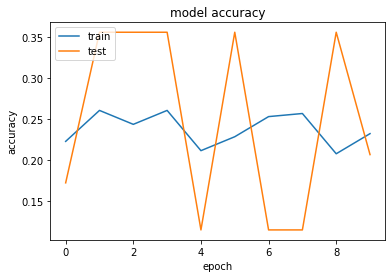

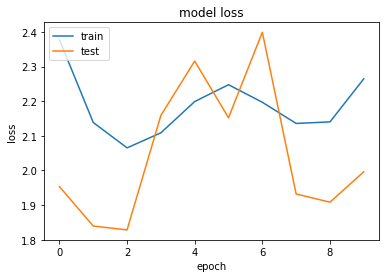

16/16 [==============================] - 48s 3s/step
Test evaluation:
16/16 [==============================] - 47s 3s/step - loss: 2.1311 - accuracy: 0.1948
[2.1310842037200928, 0.19480518996715546]
% of correct brand in the first 3 positions:
80
0.5194805194805194
% of brand predicted with percentage >= 0.25
0.44805194805194803
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


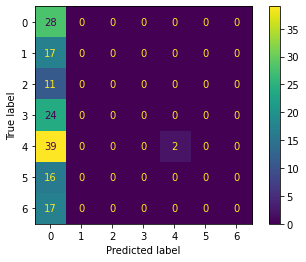

In [94]:
#vgg16 aum=True fine=0
model_pre_vgg16_no_aum_no_fine = executePreModel(shoes_train, shoes_test, shoes_val, df_shoe_brand,num_classes, False,  0, 0 )

Epoch 1/10
53/53 [==============================] - 190s 4s/step - loss: 1.2029 - accuracy: 0.5955 - val_loss: 4.7278 - val_accuracy: 0.1149
Epoch 2/10
53/53 [==============================] - 190s 4s/step - loss: 0.2785 - accuracy: 0.9112 - val_loss: 5.2535 - val_accuracy: 0.1149
Epoch 3/10
53/53 [==============================] - 185s 3s/step - loss: 0.1979 - accuracy: 0.9433 - val_loss: 3.9035 - val_accuracy: 0.1149
Epoch 4/10
53/53 [==============================] - 166s 3s/step - loss: 0.1402 - accuracy: 0.9565 - val_loss: 3.7069 - val_accuracy: 0.1149
Epoch 5/10
53/53 [==============================] - 162s 3s/step - loss: 0.1194 - accuracy: 0.9641 - val_loss: 4.0561 - val_accuracy: 0.1149
Epoch 6/10
53/53 [==============================] - 165s 3s/step - loss: 0.0877 - accuracy: 0.9754 - val_loss: 4.8375 - val_accuracy: 0.1149
Epoch 7/10
53/53 [==============================] - 163s 3s/step - loss: 0.0534 - accuracy: 0.9868 - val_loss: 6.3262 - val_accuracy: 0.1149
Epoch 8/10
53

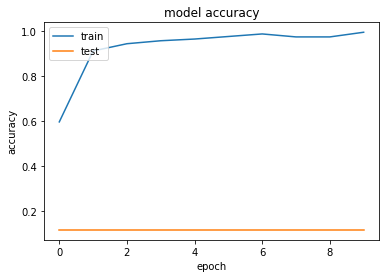

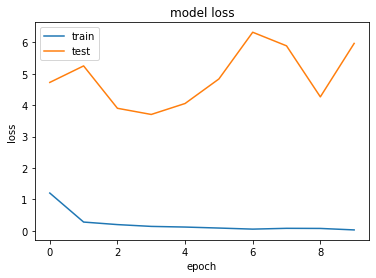

16/16 [==============================] - 41s 3s/step
Test evaluation:
16/16 [==============================] - 39s 2s/step - loss: 5.9193 - accuracy: 0.1558
[5.919312000274658, 0.15584415197372437]
% of correct brand in the first 3 positions:
82
0.5324675324675324
% of brand predicted with percentage >= 0.25
0.15584415584415584
% of brand predicted with percentage >= 0.5
0.15584415584415584
% of brand predicted with percentage >= 0.75
0.15584415584415584
Matriz de confusión:


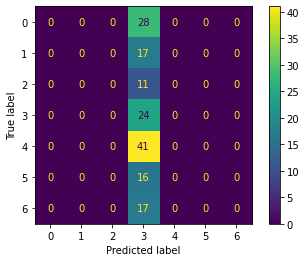

In [95]:
#vgg16, aum = true, fine=0
model_pre_vgg16_aum_no_fine = executePreModel(shoes_train, shoes_test, shoes_val, df_shoe_brand,num_classes, True,  0, 0 )

Epoch 1/10
53/53 [==============================] - 548s 10s/step - loss: 2.1159 - accuracy: 0.2306 - val_loss: 1.9374 - val_accuracy: 0.3563
Epoch 2/10
53/53 [==============================] - 502s 9s/step - loss: 1.9323 - accuracy: 0.3176 - val_loss: 1.9249 - val_accuracy: 0.3563
Epoch 3/10
53/53 [==============================] - 590s 11s/step - loss: 1.9207 - accuracy: 0.3176 - val_loss: 1.9123 - val_accuracy: 0.3563
Epoch 4/10
53/53 [==============================] - 575s 11s/step - loss: 1.9096 - accuracy: 0.3176 - val_loss: 1.9015 - val_accuracy: 0.3563
Epoch 5/10
53/53 [==============================] - 601s 11s/step - loss: 1.8997 - accuracy: 0.3176 - val_loss: 1.8909 - val_accuracy: 0.3563
Epoch 6/10
53/53 [==============================] - 617s 12s/step - loss: 1.8905 - accuracy: 0.3176 - val_loss: 1.8807 - val_accuracy: 0.3563
Epoch 7/10
53/53 [==============================] - 599s 11s/step - loss: 1.8820 - accuracy: 0.3176 - val_loss: 1.8721 - val_accuracy: 0.3563
Epoch 8

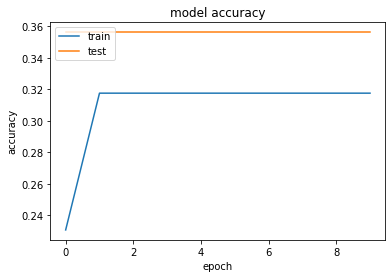

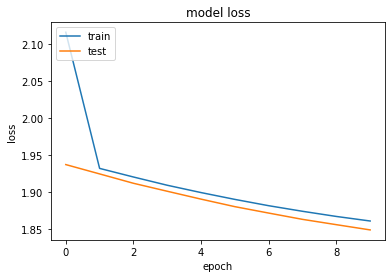

16/16 [==============================] - 50s 3s/step
Test evaluation:
16/16 [==============================] - 47s 3s/step - loss: 1.8876 - accuracy: 0.2662
[1.8875682353973389, 0.26623377203941345]
% of correct brand in the first 3 positions:
93
0.6038961038961039
% of brand predicted with percentage >= 0.25
0.0
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


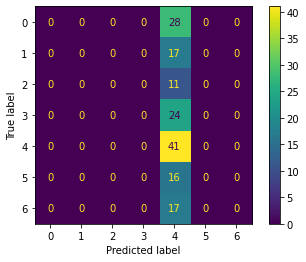

In [96]:
#vgg16, aum = false, fine=4
model_pre_vgg16_no_aum_fine = executePreModel(shoes_train, shoes_test, shoes_val, df_shoe_brand,num_classes, False,  4, 0 )

Epoch 1/10
53/53 [==============================] - 585s 11s/step - loss: 2.6669 - accuracy: 0.2684 - val_loss: 1.7942 - val_accuracy: 0.3563
Epoch 2/10
53/53 [==============================] - 609s 12s/step - loss: 1.8794 - accuracy: 0.3119 - val_loss: 1.8981 - val_accuracy: 0.3563
Epoch 3/10
53/53 [==============================] - 483s 9s/step - loss: 1.8649 - accuracy: 0.3119 - val_loss: 1.8758 - val_accuracy: 0.3563
Epoch 4/10
53/53 [==============================] - 416s 8s/step - loss: 1.8729 - accuracy: 0.2854 - val_loss: 1.8407 - val_accuracy: 0.3563
Epoch 5/10
53/53 [==============================] - 393s 7s/step - loss: 1.9455 - accuracy: 0.3081 - val_loss: 1.8500 - val_accuracy: 0.3563
Epoch 6/10
53/53 [==============================] - 423s 8s/step - loss: 1.8877 - accuracy: 0.3119 - val_loss: 1.8061 - val_accuracy: 0.3563
Epoch 7/10
53/53 [==============================] - 411s 8s/step - loss: 1.8190 - accuracy: 0.3176 - val_loss: 1.7968 - val_accuracy: 0.3563
Epoch 8/10


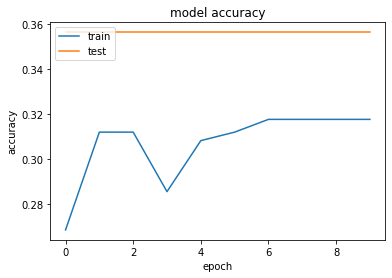

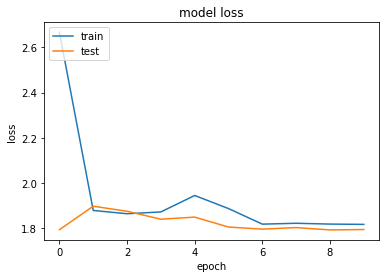

16/16 [==============================] - 39s 2s/step
Test evaluation:
16/16 [==============================] - 32s 2s/step - loss: 1.9147 - accuracy: 0.2662
[1.9146512746810913, 0.26623377203941345]
% of correct brand in the first 3 positions:
93
0.6038961038961039
% of brand predicted with percentage >= 0.25
0.2662337662337662
% of brand predicted with percentage >= 0.5
0.0
% of brand predicted with percentage >= 0.75
0.0
Matriz de confusión:


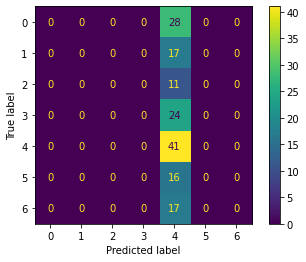

In [97]:
#vgg16, aum = true, fine=4
model_pre_vgg16_aum_fine = executePreModel(shoes_train, shoes_test, shoes_val, df_shoe_brand,num_classes, True,  4, 0 )

In [ ]:
#restnet aum=False fine=0
model_pre_rest_no_aum_no_fine = executePreModel(shoes_train, shoes_test, shoes_val, df_shoe_brand,num_classes, False,  0, 1 )

In [ ]:
#restnet aum=True fine=0
model_pre_rest_aum_no_fine = executePreModel(shoes_train, shoes_test, shoes_val, df_shoe_brand,num_classes, False,  0, 1 )

In [ ]:
#restnet aum=False fine=4
model_pre_rest_no_aum_fine = executePreModel(shoes_train, shoes_test, shoes_val, df_shoe_brand,num_classes, False,  4, 1 )

In [ ]:
#restnet aum=True fine=4
model_pre_rest_aum_fine = executePreModel(shoes_train, shoes_test, shoes_val, df_shoe_brand,num_classes, True,  4, 1 )